# Training vs validation loss

Diabetes regression

We need to track generality and prevent overfitting. Deep learning models are extremely flexible and can often get the training error down to zero.

## Support code

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [5]:
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [6]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [7]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 485.37 validation MSE 2703.16


In [8]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [9]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [10]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    28598.031
Epoch  100 MSE train loss     2433.417
Epoch  200 MSE train loss     1987.195
Epoch  300 MSE train loss     1490.350
Epoch  400 MSE train loss      990.564
Epoch  500 MSE train loss      763.126
Epoch  600 MSE train loss      522.408
Epoch  700 MSE train loss      446.526
Epoch  800 MSE train loss      352.876
Epoch  900 MSE train loss      275.599
Epoch 1000 MSE train loss      288.912


### Track validation loss and compare with plot, demonstrate overfitting

In [11]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

Epoch    0 MSE train loss    28487.514   test loss    31108.471
Epoch  100 MSE train loss     2314.574   test loss     3104.020
Epoch  200 MSE train loss     1774.656   test loss     3452.054
Epoch  300 MSE train loss     1197.026   test loss     3990.582
Epoch  400 MSE train loss      855.977   test loss     4237.697
Epoch  500 MSE train loss      632.562   test loss     4498.817
Epoch  600 MSE train loss      485.184   test loss     4780.007
Epoch  700 MSE train loss      374.337   test loss     5071.574
Epoch  800 MSE train loss      306.429   test loss     5458.111
Epoch  900 MSE train loss      304.085   test loss     5836.359
Epoch 1000 MSE train loss      224.583   test loss     5947.578


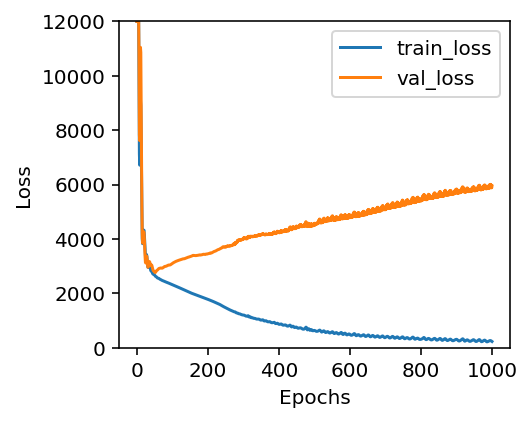

In [12]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000))

### Use weight decay to reduce overfitting

In [13]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

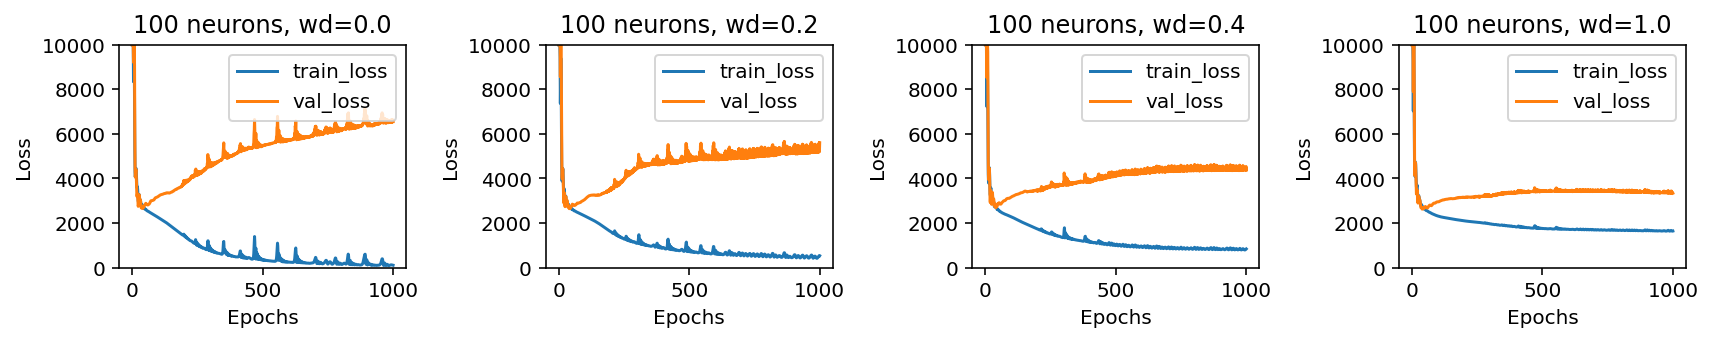

In [14]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.15, nepochs=1000, weight_decay=wd,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [15]:
def train3(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    28567.879   test loss    31192.480
Epoch  200 MSE train loss     8756.639   test loss     9148.578
Epoch  400 MSE train loss     4028.832   test loss     4193.125
Epoch  600 MSE train loss     3113.031   test loss     3294.340
Epoch  800 MSE train loss     2785.059   test loss     3063.861
Epoch 1000 MSE train loss     2637.536   test loss     3019.094
Epoch 1200 MSE train loss     2545.091   test loss     3034.717
Epoch 1400 MSE train loss     2475.310   test loss     3065.656
Epoch 1600 MSE train loss     2421.658   test loss     3099.262
Epoch 1800 MSE train loss     2379.475   test loss     3141.497
Epoch 2000 MSE train loss     2345.620   test loss     3186.293
BEST MSE test loss 3018.801
MSE test loss 3018.801


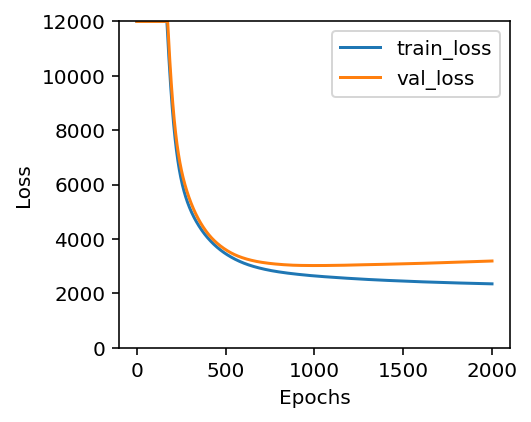

In [18]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

## Layer activation normalization

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. These activations are the input to the next layer. In this way we normalize the input to every layer.

training faster, preventing exploding or vanishing gradients, regularizing?

See video [Why Does Batch Norm Work?](https://www.youtube.com/watch?v=nUUqwaxLnWs)

Epoch    0 MSE train loss    28511.299   test loss    31129.242
Epoch  200 MSE train loss    12856.740   test loss    14221.798
Epoch  400 MSE train loss     3150.238   test loss     3829.604
Epoch  600 MSE train loss     2295.021   test loss     2967.766
Epoch  800 MSE train loss     2235.011   test loss     3033.632
Epoch 1000 MSE train loss     2199.049   test loss     3069.739
Epoch 1200 MSE train loss     2175.508   test loss     3091.296
Epoch 1400 MSE train loss     2156.465   test loss     3110.301
Epoch 1600 MSE train loss     2141.280   test loss     3151.148
Epoch 1800 MSE train loss     2127.599   test loss     3168.134
Epoch 2000 MSE train loss     2115.749   test loss     3199.160
BEST MSE test loss 2962.765
MSE test loss 2962.765


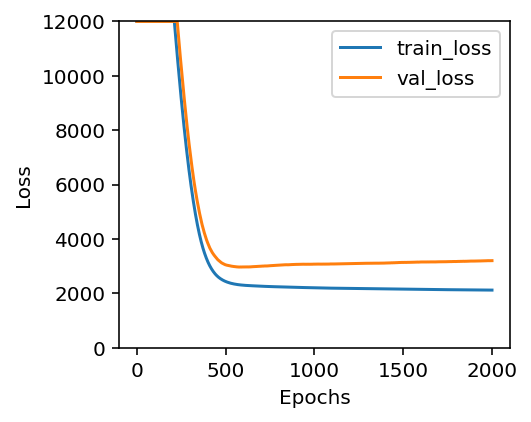

In [20]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))